# Image Captioning with Flickr30k Dataset.

## Introduction

Welcome to this notebook on Image Captioning using the Flickr30k dataset! In this project, we explore the fascinating realm of computer vision and natural language processing, aiming to generate descriptive captions for images. The task involves training a model to understand the visual content of images and generate coherent textual descriptions.

### Project Overview

**Objective:** Our goal is to build an image captioning model capable of providing meaningful and contextually relevant captions for a diverse set of images from the Flickr30k dataset.

**Approach:** We will adopt a state-of-the-art CNN-LSTM architecture, leveraging the power of Convolutional Neural Networks (CNNs) for image feature extraction and Long Short-Term Memory (LSTM) networks for sequence generation.

### Dataset Exploration

Before diving into the technical details, let's take a moment to explore the Flickr30k dataset. This collection comprises 31,000 images, each annotated with five unique captions, providing a rich source for training and evaluating our image captioning model. Understanding the dataset's structure and characteristics is crucial for building an effective model.

### Challenges and Considerations

- **Caption Length Variation:** Captions for images may vary in length, presenting a challenge in designing a model that accommodates this diversity.
- **Multimodal Features:** Exploring the combination of image features and textual information to enhance the model's understanding of the content.
- **Data Bias:** Identifying and addressing biases in the dataset to ensure the model generalizes well across diverse scenarios.


---
<span style="font-weight: bold; color: #007bff;">Now, let's take a visual tour of the Flickr30k dataset to get a sense of the images we'll be working with.</span>


In [2]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ----

# Explore & Visualize the DataSet

In [8]:
import pandas as pd
import os
import time
from tqdm import tqdm
import re

# for Explore & Visualize
from PIL import Image
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
from nltk import pos_tag
from wordcloud import WordCloud

# for preprocessing data
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from nltk.tokenize import word_tokenize

# for building the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import pickle

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
csv_path = r'C:\Users\ARYAN\AADI Miniproject\results.csv'
df = pd.read_table(csv_path, sep="|")
df.head(9)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .


In [11]:
new_columns = {
    " comment_number" : "comment_number",
    " comment" : "comment"
}
df = df.rename(columns=new_columns)

In [12]:
grouped_data = df.groupby('image_name')['comment'].apply(lambda group: group.values.tolist()).reset_index(name='comments')

In [13]:
grouped_data

,image_name,comments
0,1000092795.jpg,[ Two young guys with shaggy hair look at thei...
1,10002456.jpg,[ Several men in hard hats are operating a gia...
2,1000268201.jpg,[ A child in a pink dress is climbing up a set...
3,1000344755.jpg,[ Someone in a blue shirt and hat is standing ...
4,1000366164.jpg,"[ Two men , one in a gray shirt , one in a bla..."
...,...,...
31778,997338199.jpg,"[ Woman writing on a pad in room with gold , d..."
31779,997722733.jpg,[ A person in a red shirt climbing up a rock f...
31780,997876722.jpg,[ Two male construction workers are working on...
31781,99804383.jpg,[ An older busker in glasses plays an Eastern ...


In [15]:
# Prepare image_paths, and descriptions for the visualize_samples function
image_paths = [r'C:\Users\ARYAN\AADI Miniproject\flickr30k_images\flickr30k_images\\'+ image_name for image_name in grouped_data['image_name']]
descriptions = grouped_data['comments']

In [16]:
def visualize_samples(image_paths, descriptions, num_samples=10):

    sampled_indices = random.sample(range(len(image_paths)), min(num_samples, len(image_paths)))
    sampled_image_paths = [image_paths[i] for i in sampled_indices]
    sampled_descriptions = [descriptions[i] for i in sampled_indices]

    fig, axs = plt.subplots(num_samples, 2, figsize=(15, 20))

    for i in range(num_samples):
        img_path = sampled_image_paths[i]
        description_list = [desc.split(' ', 1)[1] for desc in sampled_descriptions[i]]

        # Load and display image
        img = mpimg.imread(img_path)
        axs[i, 0].imshow(img)
        axs[i, 0].axis('off')

        # Display multiple descriptions as text
        axs[i, 1].text(0.5, 0.5, '\n'.join(description_list), fontsize=10, va='center', ha='center', wrap=True)
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

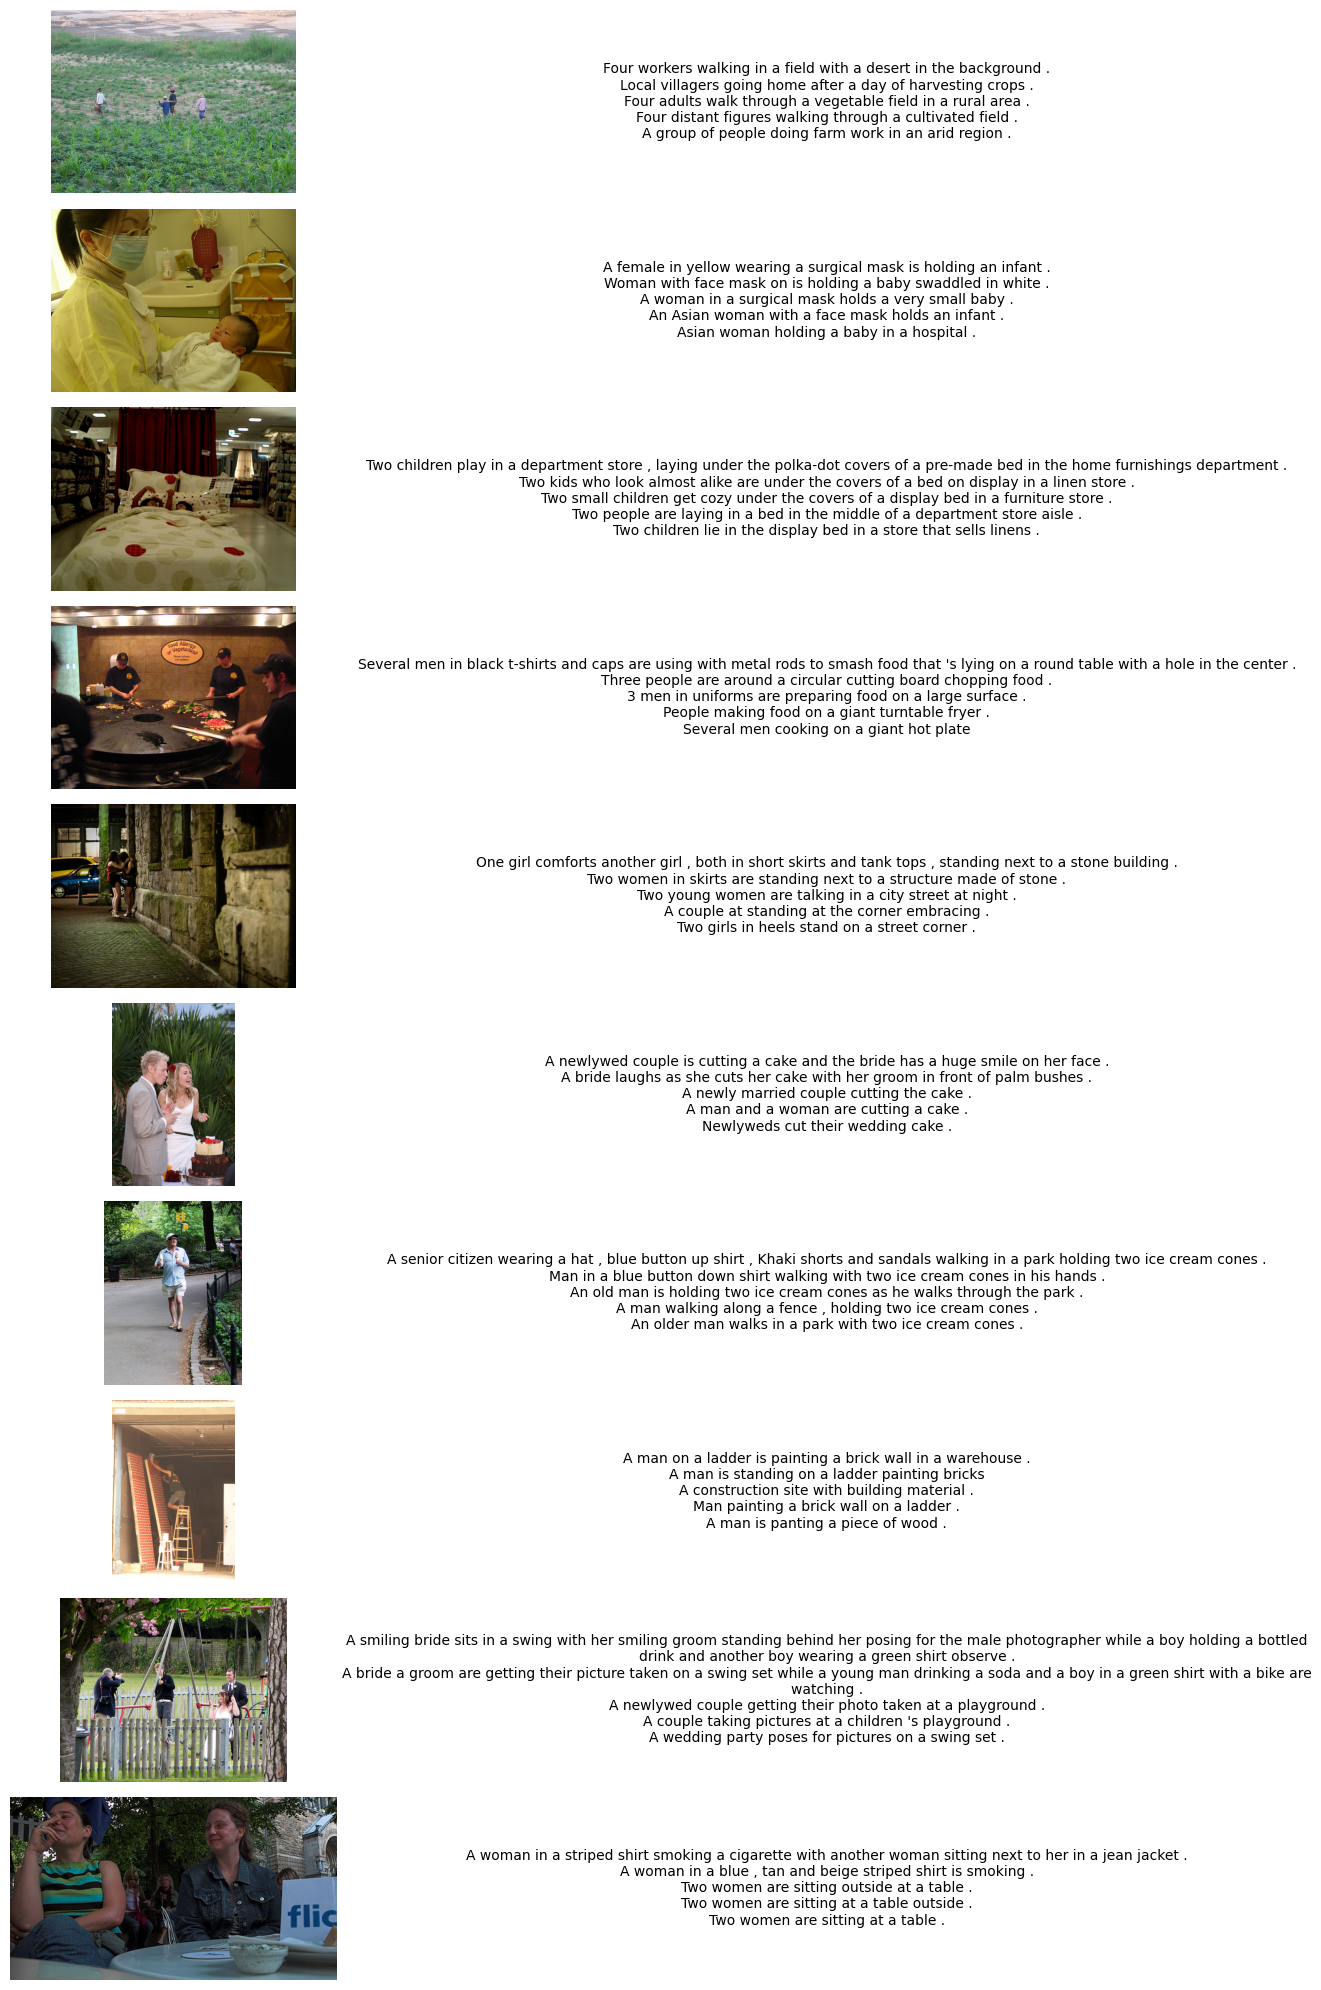

In [17]:
visualize_samples(image_paths, descriptions)

# exploratory data analysis (EDA)

### <span style="font-weight: bold; color: #007bff;">Basic Statistics:</apan>

Get basic statistics about the dataset, such as the number of unique images, comments, etc.

In [18]:
unique_images = df['image_name'].nunique()
unique_comments = df['comment'].nunique()
total_records = len(df)

print(f"Number of unique images: {unique_images}")
print(f"Number of unique comments: {unique_comments}")
print(f"Total number of records: {total_records}")

Number of unique images: 31783
Number of unique comments: 158438
Total number of records: 158915


### <span style="font-weight: bold; color: #007bff;">Distribution of Comments per Image:</span>

Visualize the distribution of comments per image to understand how many comments are typically associated with each image.

In [19]:
# comments_per_image = df.groupby('image_name')['comment'].count()

# images_with_4_comments = comments_per_image[comments_per_image == 4]
# images_with_5_comments = comments_per_image[comments_per_image == 5]

# # Plot the bar chart
# plt.figure(figsize=(10, 5))
# plt.bar([3.5, 4.5], [len(images_with_4_comments), len(images_with_5_comments)], tick_label=['4 Comments', '5 Comments'])
# plt.xlabel('Number of Comments')
# plt.ylabel('Number of Images')
# plt.title('Distribution of Comments per Image')
# plt.show()

### <span style="font-weight: bold; color: #007bff;">Word Cloud:</span>

Generate a word cloud to visualize the most frequent words in the comments.

In [20]:
# all_comments_text = ' '.join(df['comment'].fillna(''))

# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_text)
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud of Comments')
# plt.show()


In [21]:
# df['pos_tags'] = df['comment'].fillna("").apply(lambda x: pos_tag(word_tokenize(x.lower())))

# nouns = [word[0] for tags in df['pos_tags'] for word in tags if word[1].startswith('NN')]

# wordcloud_nouns = WordCloud(width=800, height=400, background_color='white').generate(' '.join(nouns))
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud_nouns, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud of Nouns in Comments')
# plt.show()

### <span style="font-weight: bold; color: #007bff;">Caption Length Distribution:</span>

Analyze the distribution of caption lengths to understand the range of caption lengths in the dataset.

In [22]:
# Caption length distribution
# df['caption_length'] = df['comment'].fillna('').apply(lambda x: len(x.split()))
# plt.hist(df['caption_length'], bins=range(1, max(df['caption_length']) + 1))
# plt.xlabel('Caption Length (in words)')
# plt.ylabel('Number of Captions')
# plt.title('Distribution of Caption Lengths')
# plt.show()


# Data Pre-processing
### <span style="font-weight: bold; color: #007bff;">Deal with the nan value:</span>
There is only one image that contains four descriptions instead of five, <span style="font-weight: bold; color: red;">I will not consider it. </span>

In [23]:
df.isna().sum()

image_name        0
comment_number    0
comment           1
dtype: int64

In [24]:
target_column = 'comment'
nan_indices = df[df[target_column].isna()]
nan_indices

,image_name,comment_number,comment
19999,2199200615.jpg,4 A dog runs across the grass .,NaN


In [25]:
image_to_delete = '2199200615.jpg'
file_name_column = 'image_name'


index_to_delete = df[df[file_name_column] == image_to_delete].index
index_to_delete

Index([19995, 19996, 19997, 19998, 19999], dtype='int64')

In [26]:
df = df.drop(index_to_delete, axis=0)
df.reset_index(drop=True, inplace=True)

In [27]:
df.isna().sum()

image_name        0
comment_number    0
comment           0
dtype: int64

In [28]:
# Extract images with 5 comments
images_with_5_comments = df.groupby('image_name').filter(lambda group: len(group) == 5)['image_name'].unique()

In [29]:
sample = '997338199.jpg'
('2199200615.jpg' in images_with_5_comments, sample in images_with_5_comments)

(False, True)

In [30]:
images_with_5_comments[:10]

array(['1000092795.jpg', '10002456.jpg', '1000268201.jpg',
       '1000344755.jpg', '1000366164.jpg', '1000523639.jpg',
       '1000919630.jpg', '10010052.jpg', '1001465944.jpg',
       '1001545525.jpg'], dtype=object)

In [31]:
df

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158905,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158906,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158907,998845445.jpg,2,A man is leaning off of the side of a blue an...
158908,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


___

### Extract Image Features (VGG16)

In [32]:
selected_df = grouped_data[grouped_data['image_name'].isin(images_with_5_comments[:10000])]
selected_df

,image_name,comments
0,1000092795.jpg,[ Two young guys with shaggy hair look at thei...
1,10002456.jpg,[ Several men in hard hats are operating a gia...
2,1000268201.jpg,[ A child in a pink dress is climbing up a set...
3,1000344755.jpg,[ Someone in a blue shirt and hat is standing ...
4,1000366164.jpg,"[ Two men , one in a gray shirt , one in a bla..."
...,...,...
9996,2952141476.jpg,[ A person is out in the water at the beach wh...
9997,295229746.jpg,[ A person in an apron is selling many differe...
9998,2952320230.jpg,[ The woman is dressed in all white swinging a...
9999,295258727.jpg,[ Two distant black dogs running across grass ...


In [33]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [34]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

<span style="font-weight: bold; color: red;">Commented for saving time..</span>

In [29]:
# image_folder_path = r"C:\Users\Acer\Image Captioning\flickr30k_images"
# image_files = selected_df.image_name.values

# feature_dict = {}
# start_time = time.time()

# for image_file in tqdm(image_files, desc="Extracting Features", unit="image"):
#     image_path = os.path.join(image_folder_path, image_file)
#     img_array = load_and_preprocess_image(image_path)

#     features = model.predict(img_array, verbose=0)

#     img_id = image_file.split('.')[0]
#     feature_dict[img_id] = features

# end_time = time.time()

# total_time = end_time - start_time
# print(f"Total execution time: {total_time} seconds")

In [53]:
features_save_path = r"C:\Users\ARYAN\AADI Miniproject\features3.pkl"

<span style="font-weight: bold; color: red;">Commented for saving time..</span>

In [54]:
# with open(features_save_path, 'wb') as file: # Save
#     pickle.dump(feature_dict, file)

In [55]:
with open(features_save_path, 'rb') as file: # Load
    loaded_features_dict = pickle.load(file)

# Text Processing

In [56]:

def preprocessing_text(data):

    data['comments'] = data['comments'].apply(lambda x: [comment.lower() for comment in x])

    data['comments'] = data['comments'].apply(lambda x: [' '.join(re.sub(r'[^a-zA-Z\s]', ' ', word) for word in comment.split() if len(word) > 1) for comment in x])

    data['comments'] = data['comments'].apply(lambda x: ['startseq ' + comment + ' endseq' for comment in x])

    return data


In [57]:
data = preprocessing_text(selected_df)

C:\Users\ARYAN\AppData\Local\Temp\ipykernel_6588\3036174236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['comments'] = data['comments'].apply(lambda x: [comment.lower() for comment in x])
C:\Users\ARYAN\AppData\Local\Temp\ipykernel_6588\3036174236.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['comments'] = data['comments'].apply(lambda x: [' '.join(re.sub(r'[^a-zA-Z\s]', ' ', word) for word in comment.split() if len(word) > 1) for comment in x])
C:\Users\ARYAN\AppData\Local\Temp\ipyke

In [58]:
data.comments.tolist()[-1]

['startseq startseq man dressed in police uniform on segway personal transportation device is in the street endseq endseq',
 'startseq startseq security guard in blue shirt moving through an airport endseq endseq',
 'startseq startseq policeman rides segway past foreign exchange counter endseq endseq',
 'startseq startseq policeman is riding vehicle through building endseq endseq',
 'startseq startseq security wearing nice clothes endseq endseq']

In [59]:
all_captions = []
for captions in data.comments:
    for caption in captions:
        all_captions.append(caption)

In [60]:
all_captions[:5]

['startseq startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq endseq',
 'startseq startseq two young white males are outside near many bushes endseq endseq',
 'startseq startseq two men in green shirts are standing in yard endseq endseq',
 'startseq startseq man in blue shirt standing in garden endseq endseq',
 'startseq startseq two friends enjoy time spent together endseq endseq']

In [61]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

11108

In [62]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

76

In [63]:
image_ids = list(loaded_features_dict.keys())
split = int(len(image_ids) * 0.97)
train = image_ids[:split]
test = image_ids[split:]

In [64]:
def custom_data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    image_inputs, sequence_inputs, output_labels = [], [], []
    while True:
        for key in data_keys:
            captions_list = mapping[key]
            for caption in captions_list:
                sequence = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(sequence)):
                    input_seq, output_seq = sequence[:i], sequence[i]
                    input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
                    image_inputs.append(features[key][0])
                    sequence_inputs.append(input_seq)
                    output_labels.append(output_seq)

            if len(image_inputs) >= batch_size:
                yield [np.array(image_inputs), np.array(sequence_inputs)], np.array(output_labels)
                image_inputs, sequence_inputs, output_labels = [], [], []


# Building & Train the model

In [65]:
# Image feature layers
image_input = Input(shape=(4096,))
image_dropout = Dropout(0.4)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Sequence feature layers
sequence_input = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 256, mask_zero=True)(sequence_input)
sequence_dropout = Dropout(0.4)(embedding_layer)
lstm_layer = LSTM(256)(sequence_dropout)


In [46]:
# Decoder model
merged_features = add([image_dense, lstm_layer])
decoder_dense1 = Dense(256, activation='relu')(merged_features)
output_layer = Dense(vocab_size, activation='softmax')(decoder_dense1)

In [47]:
# # Combine the image and sequence inputs into the model
custom_model = Model(inputs=[image_input, sequence_input], outputs=output_layer)

In [48]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
custom_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
# Plot the model architecture
plot_model(custom_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [47]:
# train the model
epochs = 100
batch_size = 64
steps = len(train) // batch_size

In [48]:
mapping = dict(zip(loaded_features_dict.keys(), data.comments.values.tolist()))

<span style="font-weight: bold; color: red;">Commented for saving time..</span>

In [49]:
for i in range(epochs):
    generator = custom_data_generator(train, mapping, loaded_features_dict, tokenizer, max_length, vocab_size, batch_size)
    custom_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

481/481 [==============================] - 347s 722ms/step - loss: 0.6487 - accuracy: 0.8091


481/481 [==============================] - 365s 760ms/step - loss: 0.5424 - accuracy: 0.8242


In [56]:
custom_model.save(r"C:\Users\Acer\Image Captioning\model01.h5") # Save

In [66]:
custom_model = load_model(r"C:\Users\ARYAN\AADI Miniproject\model01.h5")# Load

# Predict

In [67]:
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer, None)

In [72]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [73]:
def predict_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = r'C:\Users\ARYAN\AADI Miniproject\flickr30k_images\flickr30k_images\\'+image_name
    image = Image.open(img_path)
    # Predict the caption
    generated_caption = generate_caption(custom_model, loaded_features_dict[image_id], tokenizer, max_length)
    # Display the predicted caption
    print('Predicted Caption: ', generated_caption)
    # Display the image
    plt.imshow(image)
    plt.show()

In [74]:
predict_caption("3025093.jpg")  

ValueError: in user code:

    File "C:\Users\ARYAN\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\ARYAN\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ARYAN\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\ARYAN\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\ARYAN\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ARYAN\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_1" is incompatible with the layer: expected shape=(None, 74), found shape=(None, 76)


In [5]:
from tensorflow.keras.models import load_model

model_path = r"C:\Users\ARYAN\AADI Miniproject\model01.h5"  # Update the path to the saved model
custom_model = load_model(model_path)


In [6]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize the image to match the input size of the VGG16 model
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = r"C:\Users\ARYAN\OneDrive\Desktop\AADI Miniproject\Images\10815824_2997e03d76.jpg"  # Update the image path
image_features = load_and_preprocess_image(image_path)


In [7]:
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer, None)


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import numpy as np
import pickle

# Load the trained model
model_path = r"C:\Users\ARYAN\AADI Miniproject\model01.h5"  # Update the path to the saved model
custom_model = load_model(model_path)

# Load the tokenizer and max_length
tokenizer_path = r"path\to\tokenizer.pkl"  # Update the path to the saved tokenizer
max_length = 34  # Update the max_length used during training

with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)

# Define the idx_to_word function
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Define the generate_caption function
def generate_caption(model, image, tokenizer, max_length):
    generated_caption = 'startseq'
    initial_sequence = tokenizer.texts_to_sequences([generated_caption])[0]

    for _ in range(max_length):
        padded_sequence = pad_sequences([initial_sequence], maxlen=max_length)

        predictions = model.predict([image, padded_sequence], verbose=0)
        predicted_index = np.argmax(predictions)

        predicted_word = idx_to_word(predicted_index, tokenizer)
        if predicted_word is None:
            break

        if predicted_word == 'endseq':
            break

        generated_caption += " " + predicted_word
        initial_sequence.append(predicted_index)

    return generated_caption

# Define the load_and_preprocess_image function
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize the image to match the input size of the VGG16 model
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define the predict_caption function
def predict_caption(image_path):
    image_features = load_and_preprocess_image(image_path)
    caption = generate_caption(custom_model, [image_features, np.zeros((1, max_length-1))], tokenizer, max_length)
    return caption

# Test the predict_caption function
image_path = r"C:\Users\Acer\Image Captioning\flickr30k_images\2656351.jpg"  # Update the image path
predicted_caption = predict_caption(image_path)
print("Predicted Caption:", predicted_caption)
